## Ski Rental with Movie Lens
This notebook trains predictors for whether a user will watch more than b movies in the next month. 
We use these raw and calibrated predictors to compare the results of the ski-rental algorithms we propose in our paper.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal
import skirental as sr

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Section 0: Loading Data

In [2]:
movie_df = pd.read_csv('clean_data/movie_lens100k_monthly.csv')
y = movie_df['movies_this_month'].values
# Transform both feature sets
X_clf = movie_df[['age', 'gender', 'occupation', 'zip', 'movies_watched']]
X_reg = movie_df[['age', 'gender', 'movies_watched']]

# Create separate DictVectorizers for each feature set
vec_clf = DictVectorizer()
vec_reg = DictVectorizer()

X_post_clf = vec_clf.fit_transform(X_clf.to_dict('records')).toarray()
X_post_reg = vec_reg.fit_transform(X_reg.to_dict('records')).toarray()

In [273]:
n=20000
b=15*60
bike_df = pd.read_csv('clean_data/citibike-jan2015.csv').dropna().sample(n) 
# positive = bike_df[bike_df['tripduration'] >= b].sample(int(n/2))
# negative = bike_df[bike_df['tripduration'] < b].sample(int(n/2))
# joint_df = pd.concat([positive, negative])
joint_df = bike_df

X = joint_df[['birth year', 'gender', 'usertype', 'start latitude rounded', 'start longitude rounded', 'starthour']]
y = joint_df['tripduration'].values

# Create separate DictVectorizers for each feature set
vec_clf = DictVectorizer()
vec_reg = DictVectorizer()

X_post_clf = vec_clf.fit_transform(X.to_dict('records')).toarray()
X_post_reg = vec_reg.fit_transform(X.to_dict('records')).toarray()
print(X_post_clf.shape, X_post_reg.shape)

print((y>b).mean())

(20000, 6) (20000, 6)
0.17005


### Section 1: Training & Calibrating Predictors

In [97]:
# training calibrated regression model: 
i=1
X_train, X_test, y_train, y_test = train_test_split(
    X_post_reg, y, test_size=0.20, random_state=i)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.20, random_state=i)

print(f"size train: {len(X_train)}, valid: {len(X_valid)} test: {len(X_test)} ")
model = Pipeline(
            [
                ("scalar", StandardScaler()),
                #("LR", LinearRegression()), #0.002
                #("BR", BayesianRidge()) #0.06
                #("xgb", XGBRegressor()), # -0.11
                #("kernel", KernelRidge()), #-0.16
                #("SVR", SVR()), # -0.08 
                ("sgd", SGDRegressor()) # 0.07
                #("en", ElasticNet()) 0.05
                #("RFR", RandomForestRegressor()), 0.03
            ]
        )

# regular pred: 
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
rf = WrapRegressor(model)
rf.fit(X_train, y_train)
rf.calibrate(X_valid, y_valid)
conf_interval = rf.predict_int(X_test, confidence=0.7)

size train: 6400, valid: 1600 test: 2000 
0.008098461959658687


In [99]:
clf_list = ['LR', 'GB', 'XGB', 'KNN', 'RF']
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 10 
for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post_clf, y>b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in clf_list: 
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2 = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator

running model search


In [100]:
training_results_df = pd.DataFrame(training_results)

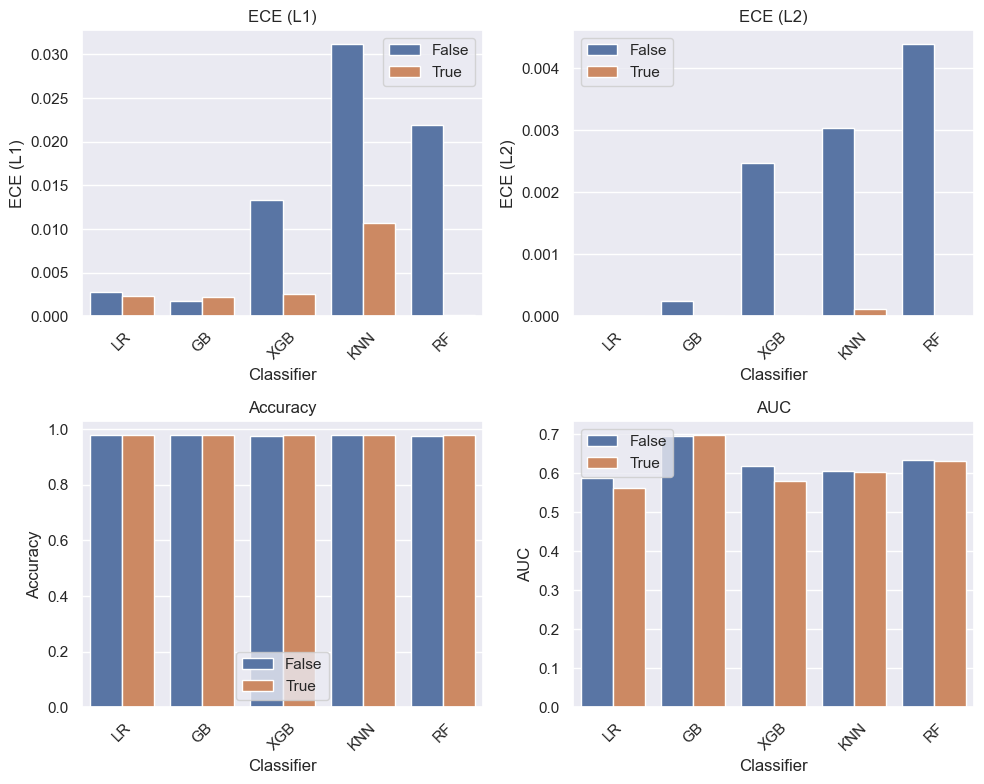

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

### Section 2: Comparing Ski Rental Algorithms

In [218]:
(y > b).mean()

np.float64(0.0218)

In [410]:
CR_df = []
bins=20
num_runs = 1
for i in range(num_runs): 
    i=2
    for b in [7*60, 10*60, 15*60, 20*60, 30*60]: 
        results_df = pd.DataFrame()
        indices = np.arange(len(X))

        # First split: separate out test set (20% of data)
        idx_temp, idx_test = train_test_split(
            indices, test_size=0.20, random_state=i
        )

        # Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
        idx_train, idx_valid = train_test_split(
            idx_temp, test_size=0.50, random_state=i
        )
        
        # regression 
        X_train = X_post_reg[idx_train]
        X_valid = X_post_reg[idx_valid]
        X_test = X_post_reg[idx_test]
        
        y_train = y[idx_train]
        y_valid = y[idx_valid]
        y_test = y[idx_test]
                        
        reg_model_name = md.get_best_regressor(X_train,
                                               y_train,
                                               X_valid,
                                               y_valid)
        
        model = Pipeline(
            [
                ("scalar", StandardScaler()),
                (reg_model_name, md.reg_dict[reg_model_name]())

            ]
        )
        rf = WrapRegressor(model)
        rf.fit(X_train, y_train)
        rf.calibrate(X_valid, y_valid)
        conf = 0.9
        results_df['delta'] = 1 - conf 
        conf_interval = rf.predict_int(X_test, confidence=conf)
        results_df['reg_sgd_val'] = model.predict(X_test)
        results_df['reg_sgd_conf_low'] = np.maximum(conf_interval[:, 0], 1)
        results_df['reg_sgd_conf_high'] = np.minimum(conf_interval[:, 1], 500)
        results_df['y'] = y_test 

        
        # classification: 
        X_train = X_post_clf[idx_train]
        X_valid = X_post_clf[idx_valid]
        X_test = X_post_clf[idx_test]
        
        y_train = y_train > b
        y_valid = y_valid > b
        y_test = y_test > b
        results_df['y_bin'] = y_test
        
        clf_model_name = md.get_best_classifier(X_train,
                                               y_train,
                                               X_valid,
                                               y_valid)
        curr_clf = md.model_choice(clf_model_name, X_train, y_train)
        curr_clf.fit(X_train, y_train)
        eps = 1 - curr_clf.score(X_valid, y_valid) 
        results_df['eps'] = eps
        
        probs = curr_clf.predict_proba(X_test)[:, 1]
        calibrator = cal.HistogramCalibrator(bins=bins)
        calibrator.calibrate(y_prob=curr_clf.predict_proba(X_valid)[:, 1], 
                             y_true=y_valid, 
                            subsample=True)
        
        y_cal_probs = calibrator.transform(probs)
        
        valid_probs = calibrator.transform(curr_clf.predict_proba(X_valid)[:, 1])
        _, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                             prob_pred=np.asarray(valid_probs),
                                             num_bins=bins, 
                                             subsample=True)
        
        print(f"calibration error new: {alpha}")
        results_df['clf_pred'] =  curr_clf.predict(X_test)
        results_df['clf_prob'] = y_cal_probs
        results_df['alpha'] = alpha
        results_df['b'] = b
        
        results_df['pip_day'] = results_df.apply(
            lambda row: sr.pip_alg(
                u=row['reg_sgd_conf_high'],
                l=row['reg_sgd_conf_high'], 
                delta=row['delta'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['bin_day'] = results_df.apply(
            lambda row: sr.regular_ski_rental(pred=row['clf_pred'],
                                           eps=row['eps'],
                                           b=row['b'], 
            ), 
            axis=1
        )

        results_df['breakeven_day'] = b

        results_df['cal_day'] = results_df.apply(
            lambda row: sr.cal_ski_rental(pred=row['clf_prob'],
                                           alpha=row['alpha'],
                                           b=row['b'], 
            ), 
            axis=1
        )
        results_df['pip_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['pip_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['bin_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['bin_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['breakeven_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['breakeven_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['cal_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['cal_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        CR_summary = results_df[['cal_CR', 'bin_CR','pip_CR', 'breakeven_CR']].mean().to_dict() 
        CR_summary['b'] = b
        CR_summary['i'] = i
        CR_df.append(CR_summary)

best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.5988573797481288
new len: 6254
new len: 6254
calibration error new: 0.004453343160305545
best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.6202410663550814
new len: 6008
new len: 6008
calibration error new: 0.004815384587408877
best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.6741354306642784
new len: 2652
new len: 2652
calibration error new: 0.005320379366180794
best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.7135746498400765
new len: 1288
new len: 1288
calibration error new: 0.004798228346456712
best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.6673412372796115
new len: 318
new len: 318
calibration error new: 0.03749999999999998


In [411]:
CR_df = pd.DataFrame(CR_df)

In [412]:
CR_df.groupby('b').mean()

,cal_CR,bin_CR,pip_CR,breakeven_CR,i
b,,,,,
420,1.608750,1.595805,1.60875,1.60875,2.0
600,1.358979,1.367173,1.36900,1.36900,2.0
900,1.169701,1.168455,1.17050,1.17050,2.0
1200,1.082490,1.082348,1.08325,1.08325,2.0
1800,1.023826,1.021415,1.02075,1.02075,2.0


Text(0, 0.5, 'CR')

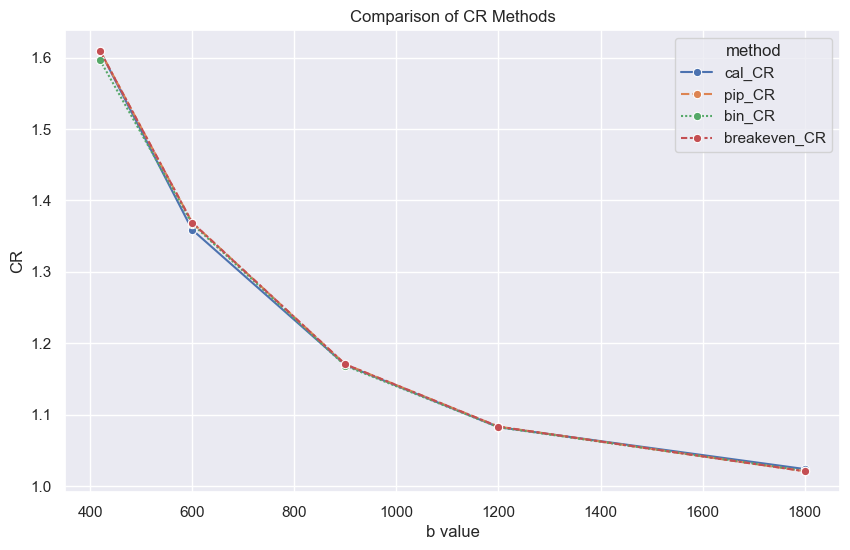

In [413]:
# Melt the DataFrame
melted_df = pd.melt(CR_df, 
                    # Keep b and i as id variables
                    id_vars=['b', 'i'],
                    # Select the CR columns to melt
                    value_vars=['cal_CR', 'pip_CR', 'bin_CR', 'breakeven_CR'],
                    # Name the new columns
                    var_name='method',
                    value_name='CR')

# Now you can plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df,
             x='b',
             y='CR',
             hue='method',
             style='method',
             marker='o')  # This will add 95% confidence intervals

plt.title('Comparison of CR Methods')
plt.xlabel('b value')
plt.ylabel('CR')

## Debugging 

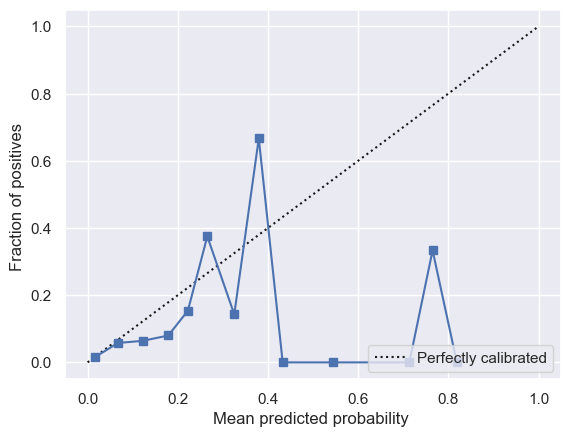

In [414]:
# display calibration 
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

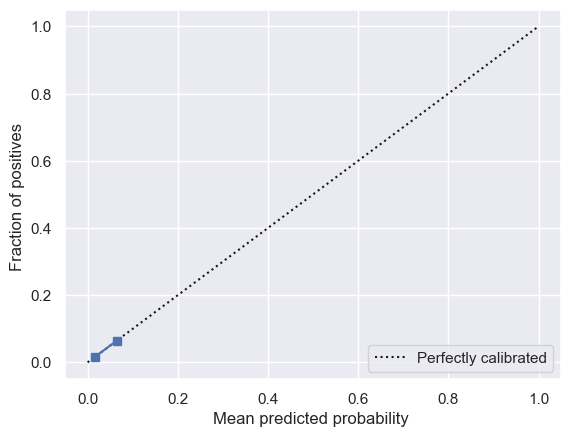

In [415]:
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
calibrator = cal.HistogramCalibrator(bins=25)
calibrator.calibrate(y_prob=y_prob, 
                     y_true=y_valid)
cal_valid_probs = calibrator.transform(y_prob)
        
prob_true, prob_pred = calibration_curve(y_valid, cal_valid_probs, n_bins=25)
disp = CalibrationDisplay(prob_true, prob_pred, cal_valid_probs)
disp.plot()

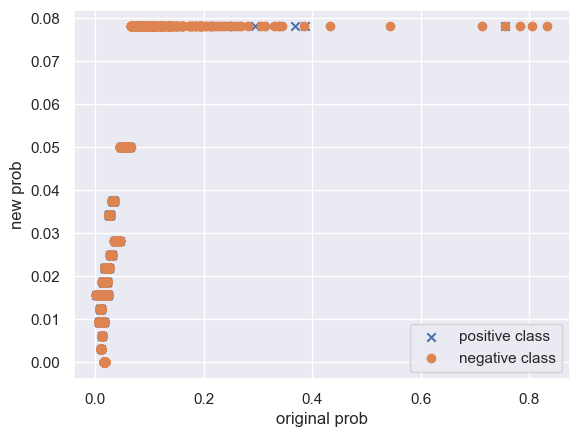

In [416]:
mask = y_valid ==1 
plt.scatter(y_prob[mask], cal_valid_probs[mask], marker='x', label='positive class')
plt.scatter(y_prob[~mask], cal_valid_probs[~mask], marker='o', label='negative class')
plt.xlabel("original prob")
plt.ylabel("new prob")
plt.legend()

In [431]:
b = 60*15
results_df = pd.DataFrame()
indices = np.arange(len(X))

# First split: separate out test set (20% of data)
idx_temp, idx_test = train_test_split(
    indices, test_size=0.20, random_state=i
)

# Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
idx_train, idx_valid = train_test_split(
    idx_temp, test_size=0.50, random_state=i
)

# regression 
X_train = X_post_reg[idx_train]
X_valid = X_post_reg[idx_valid]
X_test = X_post_reg[idx_test]

y_train = y[idx_train]
y_valid = y[idx_valid]
y_test = y[idx_test]

reg_model_name = md.get_best_regressor(X_train,
                                       y_train,
                                       X_valid,
                                       y_valid)

model = Pipeline(
    [
        ("scalar", StandardScaler()),
        (reg_model_name, md.reg_dict[reg_model_name]())

    ]
)
rf = WrapRegressor(model)
rf.fit(X_train, y_train)
rf.calibrate(X_valid, y_valid)
conf = 0.9
results_df['delta'] = 1 - conf 
conf_interval = rf.predict_int(X_test, confidence=conf)
results_df['reg_sgd_val'] = model.predict(X_test)
results_df['reg_sgd_conf_low'] = np.maximum(conf_interval[:, 0], 1)
results_df['reg_sgd_conf_high'] = np.minimum(conf_interval[:, 1], 500)
results_df['y'] = y_test 


# classification: 
X_train = X_post_clf[idx_train]
X_valid = X_post_clf[idx_valid]
X_test = X_post_clf[idx_test]

y_train = y_train > b
y_valid = y_valid > b
y_test = y_test > b
results_df['y_bin'] = y_test

clf_model_name = md.get_best_classifier(X_train,
                                       y_train,
                                       X_valid,
                                       y_valid)
curr_clf = md.model_choice(clf_model_name, X_train, y_train)
curr_clf.fit(X_train, y_train)
eps = 1 - curr_clf.score(X_valid, y_valid) 
results_df['eps'] = eps

probs = curr_clf.predict_proba(X_test)[:, 1]
calibrator = cal.HistogramCalibrator(bins=bins)
calibrator.calibrate(y_prob=curr_clf.predict_proba(X_valid)[:, 1], 
                     y_true=y_valid, 
                    subsample=True)

y_cal_probs = calibrator.transform(probs)

valid_probs = calibrator.transform(curr_clf.predict_proba(X_valid)[:, 1])
_, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                     prob_pred=np.asarray(valid_probs),
                                     num_bins=bins, 
                                     subsample=True)

print(f"calibration error new: {alpha}")
results_df['clf_pred'] =  curr_clf.predict(X_test)
results_df['clf_prob'] = y_cal_probs
results_df['alpha'] = alpha
results_df['b'] = b

        
results_df['pip_day'] = results_df.apply(
    lambda row: sr.pip_alg(
        u=row['reg_sgd_conf_high'],
        l=row['reg_sgd_conf_high'], 
        delta=row['delta'],
        b=row['b']
    ), 
    axis=1
)

results_df['bin_day'] = results_df.apply(
    lambda row: sr.regular_ski_rental(pred=row['clf_pred'],
                                   eps=row['eps'],
                                   b=row['b'], 
    ), 
    axis=1
)

results_df['breakeven_day'] = b

results_df['cal_day'] = results_df.apply(
    lambda row: sr.cal_ski_rental(pred=row['clf_prob'],
                                   alpha=row['alpha'],
                                   b=row['b'], 
    ), 
    axis=1
)
results_df['pip_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['pip_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['bin_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['bin_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['breakeven_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['breakeven_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['cal_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['cal_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df[['cal_CR', 'pip_CR','bin_CR', 'breakeven_CR']].mean()

best regressor score: xgb 0.026359081268310547
running model search
best classifier GB score: 0.6741354306642784
new len: 2652
new len: 2652
calibration error new: 0.005320379366180794


cal_CR          1.169701
pip_CR          1.170500
bin_CR          1.168455
breakeven_CR    1.170500
dtype: float64

In [432]:
# validate naive algorithm
results_df[['clf_pred',  'y_bin', 'bin_day', 'bin_CR']].value_counts()

clf_pred  y_bin  bin_day     bin_CR  
False     False  900.000000  1.000000    3282
          True   900.000000  2.000000     627
True      True   359.577878  1.399531      55
          False  359.577878  1.000000      10
                             1.879967       2
                             1.399531       1
                             3.395089       1
                             3.102409       1
                             2.805296       1
                             2.554925       1
                             2.376562       1
                             2.363186       1
                             2.106318       1
                             2.028306       1
                             1.937812       1
                             1.896955       1
                             1.838800       1
                             1.432967       1
                             1.809738       1
                             1.739748       1
                             1.695260     

In [433]:
results_df['worse'] = results_df['cal_CR'] > results_df['bin_CR']
results_df['better'] = results_df['cal_CR'] < results_df['bin_CR']

In [437]:
print("alpha", results_df['alpha'].value_counts())
print("alpha threshold", (4 + 3 * alpha) / 5)
worst_df = results_df[results_df['worse'] == True]
print("competitive ratio total diff: ", (worst_df['cal_CR']-worst_df['bin_CR']).sum())
print("cal worse than bin for : ", len(worst_df))
worst_df.groupby(['clf_pred', 'y_bin', 'clf_prob', 'bin_CR', 'cal_CR', 'cal_day', 'y']).count()

alpha alpha
0.00532    4000
Name: count, dtype: int64
alpha threshold 0.8031922276197084
competitive ratio total diff:  8.557017391458356
cal worse than bin for :  5


delta  reg_sgd_val  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                         
False    False 0.893939 1.0    1.843968 324.394832 664      0            1   
                               2.136815 324.394832 573      0            1   
                               2.509006 324.394832 488      0            1   
True     False 0.893939 1.0    3.528515 324.394832 347      0            1   
                               3.538713 324.394832 346      0            1   

                                                        reg_sgd_conf_low  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                       
False    False 0.893939 1.0    1.843968 324.394832 664                 1   
                               2.136815 324.394832 573                 1   
                               2.509006 324.394832 488                 1   
True     False 0.893939 1.0    3.528515 324.394832 347                 1   
                               3.538713 324.394832 346                 1   

                                                        reg_sgd_conf_high  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                        
False    False 0.893939 1.0    1.843968 324.394832 664                  1   
                               2.136815 324.394832 573                  1   
                               2.509006 324.394832 488                  1   
True     False 0.893939 1.0    3.528515 324.394832 347                  1   
                               3.538713 324.394832 346                  1   

                                                        eps  alpha  b  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                    
False    False 0.893939 1.0    1.843968 324.394832 664    1      1  1   
                               2.136815 324.394832 573    1      1  1   
                               2.509006 324.394832 488    1      1  1   
True     False 0.893939 1.0    3.528515 324.394832 347    1      1  1   
                               3.538713 324.394832 346    1      1  1   

                                                        pip_day  bin_day  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                       
False    False 0.893939 1.0    1.843968 324.394832 664        1        1   
                               2.136815 324.394832 573        1        1   
                               2.509006 324.394832 488        1        1   
True     False 0.893939 1.0    3.528515 324.394832 347        1        1   
                               3.538713 324.394832 346        1        1   

                                                        breakeven_day  pip_CR  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                            
False    False 0.893939 1.0    1.843968 324.394832 664              1       1   
                               2.136815 324.394832 573              1       1   
                               2.509006 324.394832 488              1       1   
True     False 0.893939 1.0    3.528515 324.394832 347              1       1   
                               3.538713 324.394832 346              1       1   

                                                        breakeven_CR  worse  \
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y                          
False    False 0.893939 1.0    1.843968 324.394832 664             1      1   
                               2.136815 324.394832 573             1      1   
                               2.509006 324.394832 488             1      1   
True     False 0.893939 1.0    3.528515 324.394832 347             1      1   
                               3.538713 324.394832 346             1      1   

                                                        better  
clf_pred y_bin clf_prob bin_CR cal_CR   cal_day    y            
False    False 0.893939 1.0    1.843968 324.394832 664       1  
                               2.136815 324.394832 573       1  
         

In [438]:
better_df = results_df[results_df['better'] == True]
print("competitive ratio total diff: ", (better_df['bin_CR']-better_df['cal_CR']).sum())
print("cal better than bin for : ", len(better_df))
better_df.groupby(['clf_pred', 'y_bin', 'clf_prob', 'bin_CR', 'cal_CR', 'cal_day', 'y']).count()

competitive ratio total diff:  3.5702744332359453
cal better than bin for :  81


delta  reg_sgd_val  \
clf_pred y_bin clf_prob bin_CR   cal_CR   cal_day    y                          
True     False 0.893939 1.399531 1.360439 324.394832 900       0            1   
                        1.432967 1.392941 324.394832 879       0            1   
                        1.439518 1.399308 324.394832 875       0            1   
                        1.487105 1.445567 324.394832 847       0            1   
                        1.510285 1.468099 324.394832 834       0            1   
...                                                          ...          ...   
         True  0.893939 1.399531 1.360439 324.394832 2046      0            1   
                                                     2153      0            1   
                                                     2176      0            1   
                                                     2224      0            1   
                                                     2560      0            1   

                                                           reg_sgd_conf_low  \
clf_pred y_bin clf_prob bin_CR   cal_CR   cal_day    y                        
True     False 0.893939 1.399531 1.360439 324.394832 900                  1   
                        1.432967 1.392941 324.394832 879                  1   
                        1.439518 1.399308 324.394832 875                  1   
                        1.487105 1.445567 324.394832 847                  1   
                        1.510285 1.468099 324.394832 834                  1   
...                                                                     ...   
         True  0.893939 1.399531 1.360439 324.394832 2046                 1   
                                                     2153                 1   
                                                     2176                 1   
                                                     2224                 1   
                                                     2560                 1   

                                                           reg_sgd_conf_high  \
clf_pred y_bin clf_prob bin_CR   cal_CR   cal_day    y                         
True     False 0.893939 1.399531 1.360439 324.394832 900                   1   
                        1.432967 1.392941 324.394832 879                   1   
                        1.439518 1.399308 324.394832 875                   1   
                        1.487105 1.445567 324.394832 847                   1   
                        1.510285 1.468099 324.394832 834                   1   
...                                                                      ...   
         True  0.893939 1.399531 1.360439 324.394832 2046                  1   
                                                     2153                  1   
                                                     2176                  1   
                                                     2224                  1   
                                                     2560                  1   

                                                           eps  alpha  b  \
clf_pred y_bin clf_prob bin_CR   cal_CR   cal_day    y                     
True     False 0.893939 1.399531 1.360439 324.394832 900     1      1  1   
                        1.432967 1.392941 324.394832 879     1      1  1   
                        1.439518 1.399308 324.394832 875     1      1  1   
                        1.487105 1.445567 324.394832 847     1      1  1   
                        1.510285 1.468099 324.394832 834     1      1  1   
...                                                        ...    ... ..   
         True  0.893939 1.399531 1.360439 324.394832 2046    1      1  1   
                                                     2153    1      1  1   
                                                     2176    1      1  1   
                                                     2224    1      1  1   
                        

In [422]:
print("delta", results_df['delta'].value_counts())
results_df.groupby(['clf_pred', 'y_bin', 'pip_CR', 'pip_day'])['y'].count()

delta Series([], Name: count, dtype: int64)


clf_pred  y_bin  pip_CR  pip_day
False     False  1.0     600        2376
          True   2.0     600        1234
True      False  1.0     600         148
          True   2.0     600         242
Name: y, dtype: int64